In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline
import torch.optim as optim
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
print(torch.__version__)
from torchsummary import summary
from torchvision.utils import save_image

1.8.0+cu101


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#https://github.com/zacheberhart/Convolutional-Disentangled-Variational-Autoencoder/blob/master/Convolutional%20Disentangled%20Variational%20Autoencoder%20(%CE%B2-VAE).ipynb

In [4]:
# EPOCH = 10
# BATCH_SIZE = 32
# LR = 0.005
# path = '/Users/ruchira/Documents/lvl_4_project/lvl4-hons-project/notebooks/train_test_imbal/'
path = '/content/drive/MyDrive/ecg/'

In [5]:
train_mlii = np.loadtxt(path+ "train_test_sampled_mlii/train_mlii.csv", delimiter=',')
test_mlii = np.loadtxt(path+"train_test_sampled_mlii/test_mlii.csv", delimiter=',')

print(train_mlii.shape)
print(test_mlii.shape)

(28936, 259)
(27207, 259)


In [6]:
X_train_old = train_mlii[:,:-3]
y_train_old = train_mlii[:,-3]
X_test_old = test_mlii[:,:-3]
y_test_old = test_mlii[:,-3]

In [7]:
# X_train_old = np.loadtxt(path + 'X_train.csv', delimiter=',')
# y_train_old = np.loadtxt(path + 'y_train.csv', delimiter=',')
# X_test_old = np.loadtxt(path + 'X_test.csv', delimiter=',')
# y_test_old = np.loadtxt(path + 'y_test.csv', delimiter=',')

In [8]:
# print(X_train_old.shape)
# print(y_train_old.shape)
# print(X_test_old.shape)
# print(y_test_old.shape)

In [9]:
num = 8.0

In [10]:
y_train = y_train_old[np.where(y_train_old == num)[0]]
X_train = X_train_old[np.where(y_train_old == num)[0]]
X_test = X_test_old[np.where(y_test_old == num)[0]]
y_test = y_test_old[np.where(y_test_old == num)[0]]

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3617, 256)
(3617,)
(1744, 256)
(1744,)


In [12]:
X_train = np.expand_dims(X_train,axis=1)
print(X_train.shape)
X_test = np.expand_dims(X_test, axis=1)
print(X_test.shape)

(3617, 1, 256)
(1744, 1, 256)


In [13]:
# print(len(train_loader.dataset))

In [14]:
# NC = 1    # channels
# NEF = 30  # init encoding filters
# NDF = 30  # init decoding filters

class VAE(nn.Module):
    
    def __init__(self, zdims, number_of_features, hidden_size, hidden_layer_depth, sequence_length, batch_size, dropout, hidden_2, c, beta, c_delta, beta_delta):
        super(VAE, self).__init__()
        
        self.zdims = zdims
        self.number_of_features = number_of_features
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        # self.latent_length = latent_length
        self.sequence_length = sequence_length
        self.batch_size=batch_size
        self.hidden_2 = hidden_2
        self.c = c
        self.beta = beta
        self.beta_delta = beta_delta
        self.c_delta = c_delta
        
        # encoder
        self.encoder = nn.LSTM(self.number_of_features, self.hidden_size, self.hidden_layer_depth, dropout = dropout)

        # decoder
        self.decoder = nn.LSTM(1, self.hidden_size, self.hidden_layer_depth)


        self.features_to_hidden = nn.Sequential(
            nn.Linear((self.batch_size*self.hidden_size), self.hidden_2),
            nn.ReLU())

        
        # conv fc
        self.fc11 = nn.Linear(90, self.zdims) # mu
        self.fc12 = nn.Linear(90, self.zdims) # logvar
        self.fc13 = nn.Linear(90, self.zdims) # log spike
        


        # deconv fc
        # self.fc2  = nn.Linear(self.zdims, self.hidden_2)
        # self.hidden_to_features = nn.Linear(self.hidden_2, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.number_of_features)

        # self.latent_to_features = nn.Sequential(
        #     nn.Linear(self.zdims, self.hidden_2), nn.ReLU(),
        #     nn.Linear(self.hidden_2, (self.hidden_size*self.batch_size)), nn.ReLU()
        # )
        self.latent_to_features = nn.Sequential(nn.Linear(self.zdims, 90),
                                                nn.ReLU())

        self.decoder_inputs = torch.zeros(self.sequence_length, self.batch_size, 1, requires_grad=True).type(torch.cuda.FloatTensor)
        self.c_0 = torch.zeros(self.hidden_layer_depth, self.batch_size, self.hidden_size, requires_grad=True).type(torch.cuda.FloatTensor)


        # nn.init.xavier_uniform_(self.fc11.weight)
        # nn.init.xavier_uniform_(self.fc12.weight)
        # nn.init.xavier_uniform_(self.fc13.weight)
        # nn.init.xavier_uniform_(self.fc2.weight)
        # nn.init.xavier_uniform_(self.latent_to_features.weight)
        # nn.init.xavier_uniform_(self.fc3.weight)
        # nn.init.xavier_uniform_(self.hidden_to_features.weight)
        # nn.init.xavier_uniform_(self.features_to_hidden.weight)

    def encode(self, x):
#         import pdb; pdb.set_trace()
        # print("encode", x.shape)
        # x = x.permute(0,2,1)
        # print("after permute", x.shape)
        _, (h_end, c_end) = self.encoder(x)
        
        # conv = conv.view(BATCH_SIZE,-1) # this maybe the problem -1,30
        # print("conv after view", conv.shape)
        h_end = h_end[-1, :, :] # !!!!!!!!!!!!!
        # print("conv", h_end.shape)

        # h_end_flat = torch.flatten(h_end)
        # print("conv flat", h_end_flat.shape)
        # hidden = self.features_to_hidden(h_end_flat)
        # print("hidden conv", hidden.shape)
        conv = h_end.view(BATCH_SIZE, -1)
        # print(conv.shape)
        mu = self.fc11(conv)
        # print("mu", mu.shape)
        logvar = self.fc12(conv)
        # print("logvar", logvar.shape)
        logspike = self.fc13(conv)

        return mu, logvar, logspike
    
    def decode(self, z):
        # import pdb; pdb.set_trace()
        # print("z", z.shape)
        # h_state = F.relu(self.fc2(z)) # try without relu

        h_state = self.latent_to_features(z)
        # print("deconv before view ", h_state.shape)
        h_state = h_state.view(BATCH_SIZE, hidden_size)
        # print("deconv after view ", h_state.shape)
        # deconv_input = deconv_input.view(BATCH_SIZE,32,256)

        h_0 = torch.stack([h_state for _ in range(self.hidden_layer_depth)])
        decoder_output, _ = self.decoder(self.decoder_inputs, (h_0, self.c_0))

        # deconv_input = torch.unsqueeze(deconv_input,2)# world models: [-1, 1, 1, 1024] # and this # 30,1024,430
        # print("after view", deconv_input.shape)
        # recon_x = self.decoder(deconv_input)
        # print("deconv before fc3", decoder_output.shape)
        out = self.fc3(decoder_output)
        # print("deconv after fc3", out.shape)
        return out
        # return recon_x

    # def decode_latent(self, z):
    #     # import pdb; pdb.set_trace()
    #     deconv_input = F.relu(self.fc2(z))
    #     # print(deconv_input.shape)
    #     # deconv_input = deconv_input.view(BATCH_SIZE,32,256) # world models: [-1, 1, 1, 1024] # and this # 30,1024,430
    #     recon_x = self.decoder(deconv_input)
    #     return recon_x
    
    def reparameterize(self, mu, logvar, logspike):
        std = torch.exp(logvar * 0.5)
        eps = torch.rand_like(std)
        z = eps.mul(std).add(mu)
        eta = torch.rand_like(std)
        selection = torch.sigmoid(self.c*(eta + logspike.exp() - 1))
        return selection.mul(z)
    
    def forward(self, x):
        # print("forward", x.shape)
        mu, logvar, logspike = self.encode(x)
        z = self.reparameterize(mu, logvar, logspike)
        # print(z.shape, "z, forward")
        recon_x = self.decode(z)
        # recon_x = recon_x.permute(0,2,1)
        return recon_x, mu, logvar, logspike, z
  
    def update_c(self):
      self.c += self.c_delta
      
    def update_beta(self):
      self.beta += self.beta_delta


In [15]:
print(X_train.shape)

(3617, 1, 256)


In [16]:
CUDA = True

ZDIMS = 20
# BETA = 5
LR = 1e-3
EPOCHS = 25
BATCH_SIZE = 64
SEED = 4
LOG_INTERVAL = 100


hidden_2 = 60
hidden_size = 90
hidden_layer_depth = 4
# latent_length = 20
batch_size = 64
learning_rate = 0.0005
n_epochs = 10
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = False
sequence_length = X_train.shape[1]
features = X_train.shape[2]
c=50
c_delta=0.001
beta=0.1
beta_delta=0

In [17]:
torch.manual_seed(SEED)
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [18]:
tensor_Xtrain = torch.from_numpy(X_train)
tensor_ytrain = torch.from_numpy(y_train)

train_data = Data.TensorDataset(tensor_Xtrain, tensor_ytrain)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [19]:
tensor_Xtest = torch.from_numpy(X_test)
tensor_ytest = torch.from_numpy(y_test)

test_data = Data.TensorDataset(tensor_Xtest, tensor_ytest)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [20]:
model = VAE(zdims = ZDIMS, number_of_features=features,hidden_size=hidden_size, hidden_layer_depth=hidden_layer_depth, sequence_length= sequence_length, batch_size=batch_size, dropout=dropout_rate, hidden_2=hidden_2, c=c, beta=beta, c_delta=c_delta, beta_delta=beta_delta).to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)

In [21]:
print(model)

VAE(
  (encoder): LSTM(256, 90, num_layers=4, dropout=0.2)
  (decoder): LSTM(1, 90, num_layers=4)
  (features_to_hidden): Sequential(
    (0): Linear(in_features=5760, out_features=60, bias=True)
    (1): ReLU()
  )
  (fc11): Linear(in_features=90, out_features=20, bias=True)
  (fc12): Linear(in_features=90, out_features=20, bias=True)
  (fc13): Linear(in_features=90, out_features=20, bias=True)
  (fc3): Linear(in_features=90, out_features=256, bias=True)
  (latent_to_features): Sequential(
    (0): Linear(in_features=20, out_features=90, bias=True)
    (1): ReLU()
  )
)


In [22]:
# def loss_function(recon_x, x, mu, logvar, beta = 1):
#     '''Use a beta value of 1 for a vanilla VAE'''
#     # print(recon_x.shape, "recon_x")
#     # print(x.shape, "x")
#     # loss
#     # BCE = F.binary_cross_entropy(recon_x, x, reduction = 'sum')
#     MSE = F.mse_loss(recon_x,x,reduction= 'mean')
#     # KL Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
#     return MSE + (beta * KLD)

def loss_function(recon_x, x, mu, logvar, logspike):
    '''Use a beta value of 1 for a vanilla VAE'''
    # print(recon_x.shape, "recon_x")
    # print(x.shape, "x")
    # loss
    flat_shape = 64*256
    alpha = 0.5
    # BCE = F.binary_cross_entropy(recon_x.view(-1, flat_shape), x.view(-1, flat_shape), size_average=False)
    MSE = F.mse_loss(recon_x.view(-1, flat_shape), x.view(-1, flat_shape),reduction= 'mean')
    # KL Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    spike = torch.clamp(logspike.exp(), 1e-6, 1.0 - 1e-6)

    prior1 = -0.5 * torch.sum(spike.mul(1 + logvar - mu.pow(2) - logvar.exp()))
    prior21 = (1 - spike).mul(torch.log((1 - spike) / (1 - alpha)))
    prior22 = spike.mul(torch.log(spike / alpha))
    prior2 = torch.sum(prior21 + prior22)
    PRIOR = prior1 + prior2
    LOSS = MSE + model.beta * PRIOR
    # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # return MSE + (beta * KLD)
    return LOSS, PRIOR, MSE

In [23]:
def train(epoch, beta = 1):

    model.train()
    train_loss = 0
    prior_loss = 0
    mse_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        # data = data[0]
        data = data.to(device)
        # print("data", data.shape)
        data = data.permute(1,0,2)
        optimizer.zero_grad()
        # inp = data.view(len(data), 1, 430).type(torch.cuda.FloatTensor)
        # print(inp.shape)
        # print("view", data.view(len(data), 1, 256).shape)
        # data = data.permute(2,0,1)
        recon_batch, mu, logvar, logspike, Z = model(data.type(torch.cuda.FloatTensor))
        # print(recon_batch.shape, "recon_batch")
#         print(mu.shape, "mu")
#         print(Z.shape, "Z")
        
        loss, prior, mse = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar, logspike)
        loss.backward()
        train_loss += loss.item()
        prior_loss += prior.item()
        mse_loss += mse.item()
        optimizer.step()
        
        model.update_c()
        model.update_beta()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)
            ))
        
    if epoch==99:
        f, a = plt.subplots(2, 5, figsize=(20,5))
        view_data = data[:5].view(-1, 256).type(torch.cuda.FloatTensor)
        view_recon = recon_batch[:5].view(-1, 256).type(torch.cuda.FloatTensor)

        for i in range(5):
            a[0][i].plot(view_data.cpu().data.numpy()[i])

        for i in range(5):
            a[1][i].clear()
            a[1][i].plot(view_recon.cpu().data.numpy()[i])
        plt.show();
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch,
        train_loss / len(train_loader.dataset)
    ))
    return train_loss / len(train_loader.dataset), prior_loss / len(train_loader.dataset), mse_loss / len(train_loader.dataset)

In [24]:
train_loss_list = []
prior_list = []
mse_list = []
for epoch in range(50):
    loss, prior, mse = train(epoch)
    train_loss_list.append(loss)
    prior_list.append(prior)
    mse_list.append(mse)

Train Epoch: 0 [0/3617 (0%)]	Loss: 80.402847
====> Epoch: 0 Average loss: 0.8346
Train Epoch: 1 [0/3617 (0%)]	Loss: 40.858513
====> Epoch: 1 Average loss: 0.6267
Train Epoch: 2 [0/3617 (0%)]	Loss: 40.373352
====> Epoch: 2 Average loss: 0.6257
Train Epoch: 3 [0/3617 (0%)]	Loss: 40.403484
====> Epoch: 3 Average loss: 0.6255
Train Epoch: 4 [0/3617 (0%)]	Loss: 40.338734
====> Epoch: 4 Average loss: 0.6253
Train Epoch: 5 [0/3617 (0%)]	Loss: 40.408669
====> Epoch: 5 Average loss: 0.6252
Train Epoch: 6 [0/3617 (0%)]	Loss: 40.312599
====> Epoch: 6 Average loss: 0.6251
Train Epoch: 7 [0/3617 (0%)]	Loss: 40.381748
====> Epoch: 7 Average loss: 0.6250
Train Epoch: 8 [0/3617 (0%)]	Loss: 40.419971
====> Epoch: 8 Average loss: 0.6249
Train Epoch: 9 [0/3617 (0%)]	Loss: 40.413673
====> Epoch: 9 Average loss: 0.6248
Train Epoch: 10 [0/3617 (0%)]	Loss: 40.332661
====> Epoch: 10 Average loss: 0.6247
Train Epoch: 11 [0/3617 (0%)]	Loss: 40.386097
====> Epoch: 11 Average loss: 0.6246
Train Epoch: 12 [0/3617 

In [25]:
def plot_image(img, ax, title):
    view_data = img
    time_value = np.arange(256, dtype = 'float')
    ax.plot(time_value, view_data)
    ax.set_title(title, fontsize=20)


def plot_encoding(image, model, latent_sz, alpha=1, width=1/7):
    image = image[0]
    image.to(device)
    image = image.permute(1,0,2)
    decoded, mu, logvar, logspike, z = model.forward(image.type(torch.cuda.FloatTensor))
    z = model.reparameterize(mu, logvar, logspike)
    img = model.decode(z).view(-1,256).detach().cpu().numpy()
    z = z.cpu().detach().numpy()[0]
    # print(z.shape)
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
    
    plot_image(image[0,0,:], ax0, 'Input Image')
    
    ax1.bar(np.arange(latent_sz), height=z, width=width, align='center')
    ax1.scatter(np.arange(latent_sz), z, color='blue')
    ax1.set_title(r"Latent Dimension %d" % latent_sz, fontsize=20)
    
    plot_image(img[0,:], ax2, 'Decoded Image')
    plt.subplots_adjust(hspace=0.5)

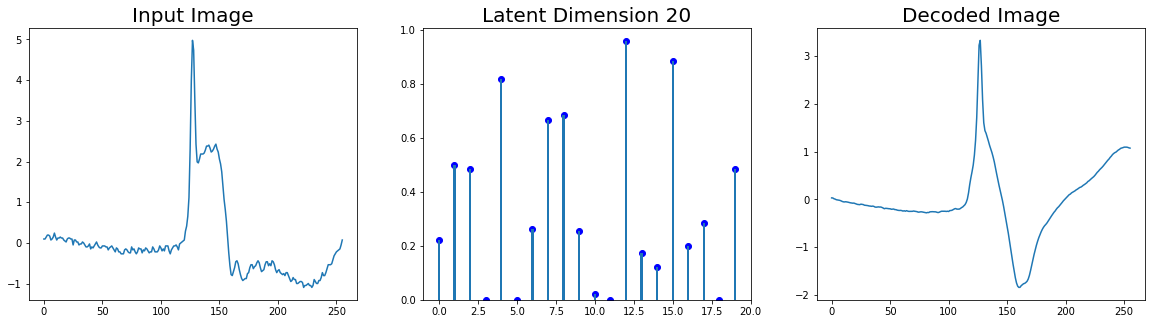

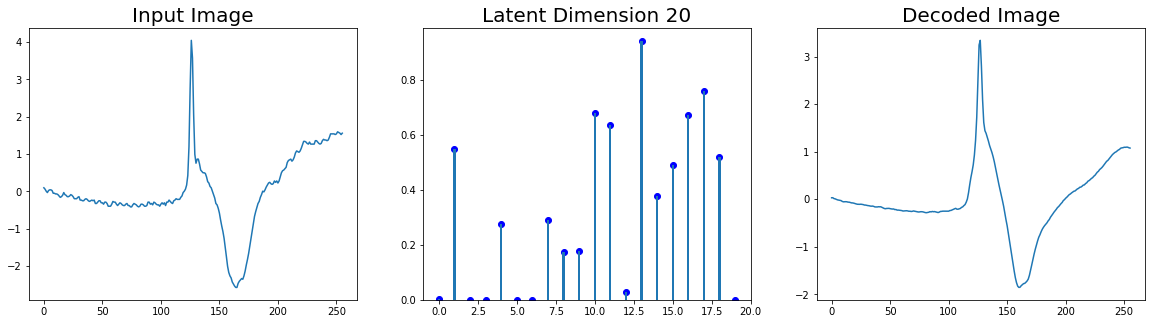

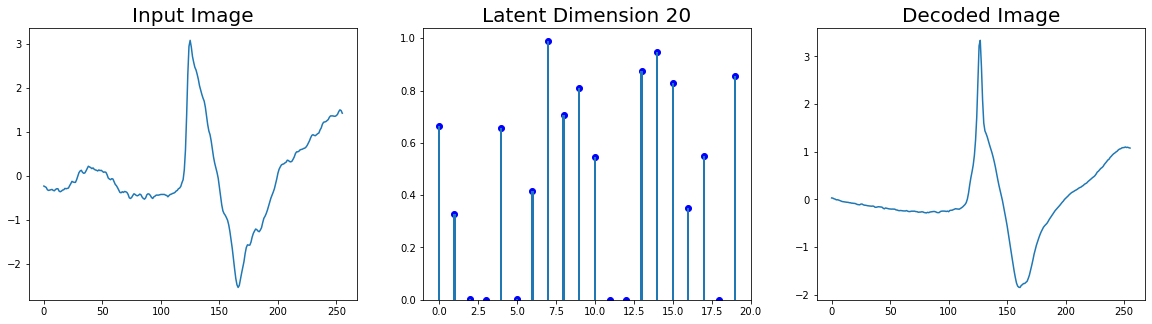

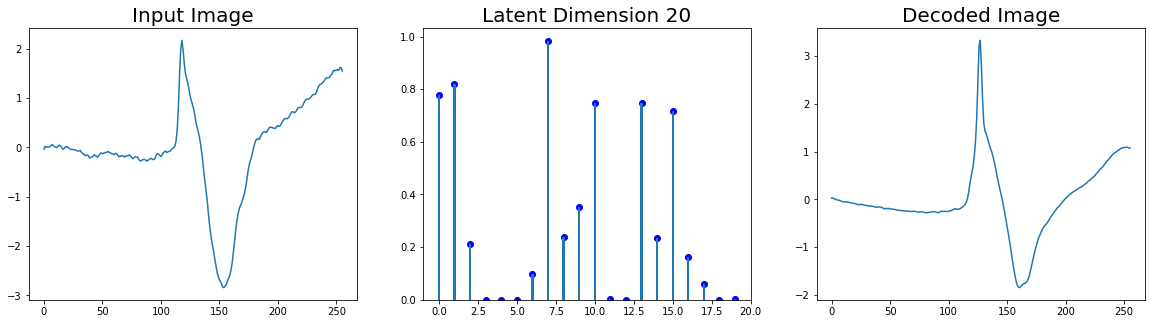

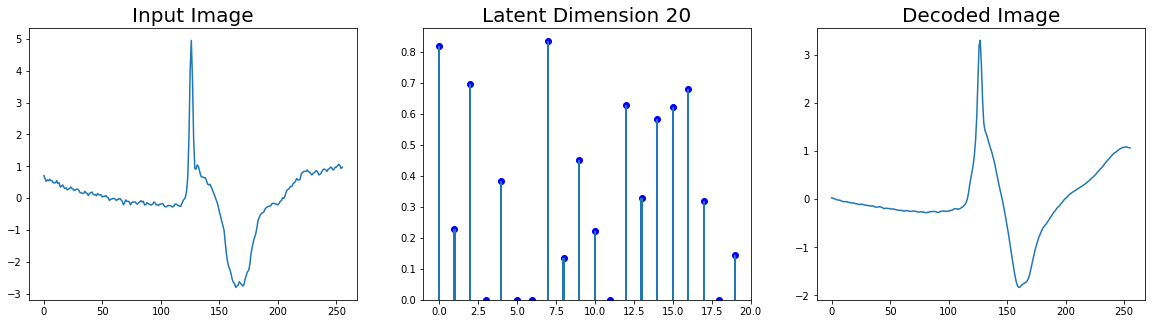

In [26]:
dataloader_iterator = iter(train_loader)
for i in range(5):
    try:
        img = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(train_loader)
        img = next(dataloader_iterator)
    plot_encoding(img, model, ZDIMS)

In [27]:
# from sklearn.manifold import TSNE 
# latent_ecg = []
# target = []
# for data, targets in train_loader:
#     z_means, z_logvar, z_logspike = model.encode(data.permute(1,0,2).type(torch.cuda.FloatTensor))
#     # print(z_means.shape)
#     latent_ecg.extend(z_means.detach().cpu().numpy())
#     target.extend(targets.numpy())

# # take first 1k
# latent = np.array(latent_ecg)
# # print(latent.shape)
# target = np.array(target)
# tsne = TSNE(n_components=2, random_state=0, verbose=2, n_iter=500)

# X = tsne.fit_transform(latent_ecg)

In [28]:
# plt.figure(figsize=(8,8))
# scatter = plt.scatter(X[:,0], X[:,1], c=target)
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('TSNE')
# plt.show()

In [29]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    recon_list = []
    prior_loss_tst = 0
    mse_loss_tst = 0
    with torch.no_grad():
        
        for i, (data,_) in enumerate(test_loader):
            # data = data[0]
            data = data.to(device)
            data= data.permute(1,0,2)
            # data_reshape = data.view(len(data), 1, 256).type(torch.cuda.FloatTensor)
            recon_batch, mu, logvar, logspike, Z = model(data.type(torch.cuda.FloatTensor))
            recon_list.append(recon_batch)
            # print(recon_batch.shape)
            loss, prior, mse = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar, logspike)
            test_loss += loss.item()
            prior_loss_tst += prior.item()
            mse_loss_tst += mse.item()
            # if i == 0:
    n = min(data.size(0), 8)
    comparison = torch.cat([data[:n], recon_batch[:n]])
    # print(comparison)
    # save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow = n)
    if epoch==99:
      f, a = plt.subplots(2, 5, figsize=(20,5))
      view_data = data[:5].view(-1, 256).type(torch.cuda.FloatTensor)
      view_recon = recon_batch[:5].view(-1, 256).type(torch.cuda.FloatTensor)

      for i in range(5):
          a[0][i].plot(view_data.cpu().data.numpy()[i])

      for i in range(5):
          a[1][i].clear()
          a[1][i].plot(view_recon.cpu().data.numpy()[i])
      plt.show();
    test_loss /= len(test_loader.dataset)
    prior_loss_tst /= len(test_loader.dataset)
    mse_loss_tst /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss, prior_loss_tst, mse_loss_tst,  recon_list

In [30]:
test_loss_list = []
prior_list_tst = []
mse_list_tst = []
for epoch in range(50):
    loss, prior, mse, recon_list = test(epoch)
    test_loss_list.append(loss)
    prior_list_tst.append(prior)
    mse_list_tst.append(mse)

====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6246
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss: 0.6247
====> Test set loss:

In [31]:
print(recon_list[0].shape)

torch.Size([1, 64, 256])


In [32]:
copy_recon = recon_list
recon_all = torch.cat(copy_recon, dim=1)
print(recon_all.shape)

torch.Size([1, 1728, 256])


In [33]:
recon_all_1 = torch.squeeze(recon_all, dim=0)
print(recon_all_1.shape)

torch.Size([1728, 256])


In [34]:
# # sample from latent space
# with torch.no_grad():
#     sample = torch.randn(64,ZDIMS).to(device)
#     print(sample.shape)
#     sample = model.decode(sample).cpu()
#     f, a = plt.subplots(1, 2, figsize=(20,5))
#     samp_view = sample.reshape(-1,256)
#     view_data = samp_view[45:55]

#     for i in range(2):
#         a[i].plot(view_data.cpu().data.numpy()[i])

#     # for i in range(5):
#     #     a[1][i].clear()
#     #     a[1][i].plot(view_recon.cpu().data.numpy()[i])
#     plt.show();

def sample_latent(model, no_samples):
  samples = []
  with torch.no_grad():
    for i in range(no_samples // 64):
      sample = torch.randn(64, ZDIMS).to(device)
      # print(sample.shape)
      sample = model.decode(sample).cpu()
      sample = sample.reshape(-1,256)
      # print(sample.shape)
      # sample = scaler.inverse_transform(sample.view(-1,256).cpu().data.numpy())
      # sample = sample.permute(0,2,1)
      # print(sample.shape)
      samples.append(sample)
    return samples

In [35]:
samples = sample_latent(model,3000)
print(len(samples))

46


In [36]:
print(samples[0].shape)
all_samps = np.concatenate(samples, axis=0)
print(all_samps.shape)

torch.Size([64, 256])
(2944, 256)


In [37]:
import os
sv_samps = '/content/drive/MyDrive/ecg/synthetic_data/lstm_sparse_vae/beat_type' + str(num) + '.csv'
if not os.path.exists('/content/drive/MyDrive/ecg/synthetic_data/lstm_sparse_vae/'):
  os.makedirs('/content/drive/MyDrive/ecg/synthetic_data/lstm_sparse_vae/')
np.savetxt(sv_samps, all_samps, delimiter=',', fmt='%f')

In [38]:
def view_samples(sample):
  f, a = plt.subplots(1, 5, figsize=(40,5))
  view_data = sample[30:35]

  for i in range(5):
      a[i].plot(view_data[i])

      # for i in range(5):
      #     a[1][i].clear()
      #     a[1][i].plot(view_recon.cpu().data.numpy()[i])
  plt.show();

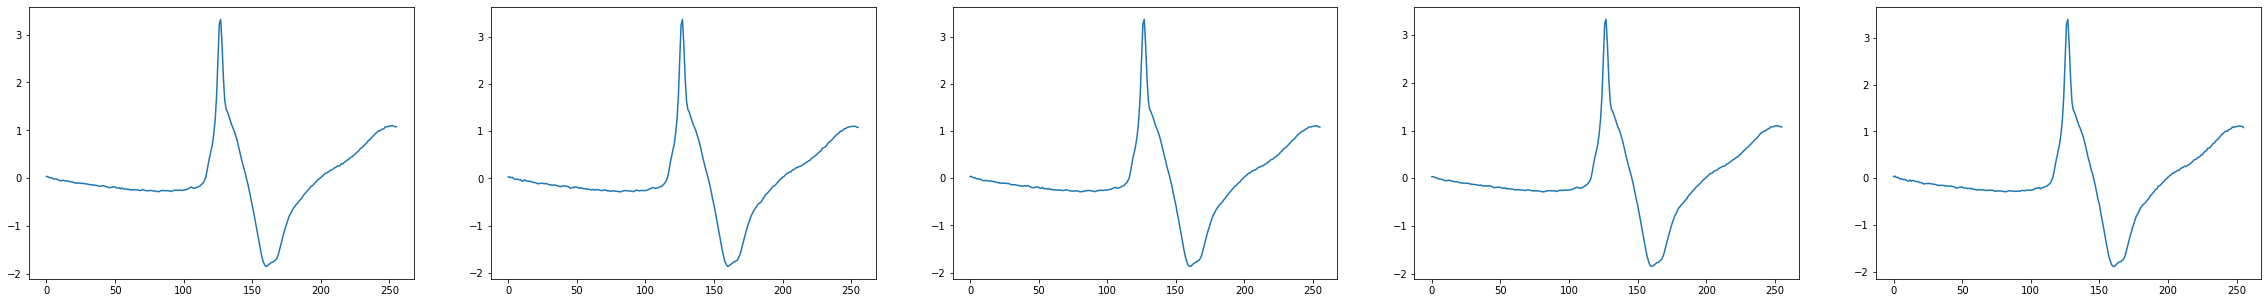

In [39]:
view_samples(all_samps)

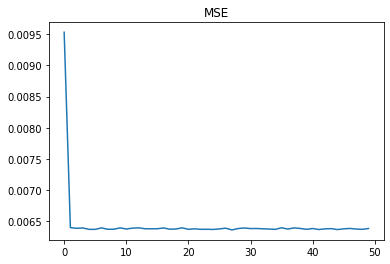

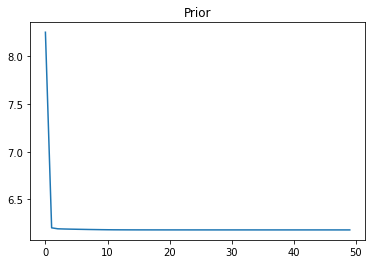

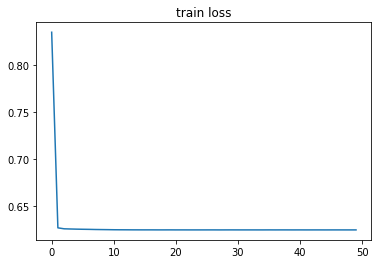

In [40]:
plt.plot(range(len(mse_list)), mse_list)
plt.title("MSE")
plt.show()
plt.plot(range(len(prior_list)), prior_list)
plt.title("Prior")
plt.show()
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.title("train loss")
plt.show()

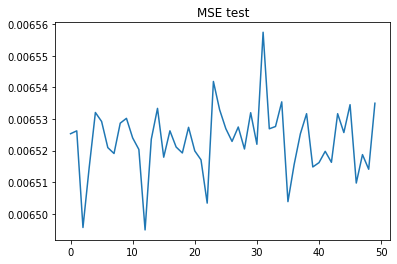

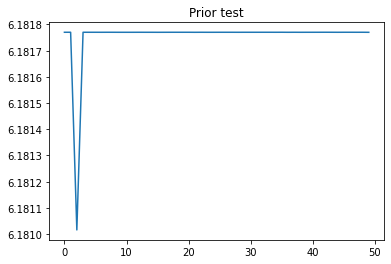

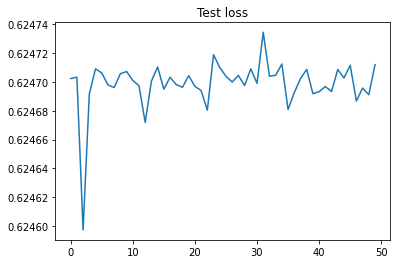

In [41]:
plt.plot(range(len(mse_list_tst)), mse_list_tst)
plt.title("MSE test")
plt.show()
plt.plot(range(len(prior_list_tst)), prior_list_tst)
plt.title("Prior test")
plt.show()
plt.plot(range(len(test_loss_list)), test_loss_list)
plt.title("Test loss")
plt.show()

In [42]:
# data = recon_all_1.cpu().data.numpy()
# classes = y_test[:-7]
# print(classes.shape)

In [43]:
# from sklearn.decomposition import PCA
# x_pca = PCA(n_components=50,random_state=42).fit_transform(data)
# plt.figure(figsize=(8,8))

# categories=['N','L','R','V','A','F','f','/']
# scatter = plt.scatter(x_pca[:,0],x_pca[:,1],c=classes, cmap='inferno_r')
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('PCA')

In [44]:
# from sklearn.manifold import TSNE
# x_tsne = TSNE(n_components=2,random_state=42,perplexity=100, verbose=5, n_iter=500).fit_transform(x_pca)
# plt.figure(figsize=(8,8))

# categories=['N','L','R','V','A','F','f','/']
# scatter = plt.scatter(x_tsne[:,0],x_tsne[:,1],c=classes, cmap='inferno_r')
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('PCA and TSNE')

In [45]:
# import umap
# reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=100, a = 0.5, b = 1.2)
# embedding = reducer.fit_transform(x_pca)
# embedding.shape
# plt.figure(figsize=(8,8))

# plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=classes, cmap='inferno')
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('PCA and UMAP')